In [1]:
# import necessary packages
import math, argparse
import numpy as np
from numpy import random
import torch
import torch.nn as nn
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# set seed to ensure reproducibility
SEED = 8
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

# Data

In [2]:
# prepare dummy data
X, y = datasets.make_regression(n_samples=100, n_features=20, noise=80, random_state=SEED)
# apply the bias trick
X = np.c_[np.ones(X.shape[0]), X] 
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
n_samples, n_features = X_train.shape


# Model 

## Linear regression using gradient descent from scratch

### Without ridge penalty

In [3]:
class GD_regression:
    def __init__(self, lr=1e-3, num_epochs=1000, l2_penalty=0):
        self.lr = lr
        self.num_epochs = num_epochs
        self.l2_penalty = l2_penalty
        self.train_loss = []
        self.test_loss = []

    # function to estimate model coefficients
    def fit(self, X_train, y_train, X_test, y_test):
        # initialize weights to be an array of zeros
        weights = np.zeros(X_train.shape[1])
        # iteration counter
        epoch = 0 
        # while not reaching maximum number of iterations:
        while epoch < self.num_epochs:
            # increment iteration counter
            epoch += 1  
            # compute the predictions based on current weights
            predictions = np.dot(X_train, weights)
            # compute the errors as predictions - output
            errors = predictions.reshape(-1,1) - y_train.reshape(-1,1)
            # coordinate descent over each weight
            for i in range(len(weights)): 
                # compute the derivative for the ith weight
                if i == 0:
                    # compute the derivative of the constant weight when i=0
                    derivative = self.feature_derivative_ridge(errors, X_train[:,i].reshape(1,-1), 
                                            weights[i], self.l2_penalty, True)
                else:
                    # compute the derivative of all other weights
                    derivative = self.feature_derivative_ridge(errors, X_train[:,i].reshape(1,-1), 
                                            weights[i], self.l2_penalty, False)
                # gradient descent update for each coordinate/weight
                weights[i] = weights[i] - self.lr * derivative

            # score using training and test sets
            self.train_loss.append(self.calculate_mse(X_train, y_train, weights))
            self.test_loss.append(self.calculate_mse(X_test, y_test, weights))
        # store the final weights
        self.weights = weights
        return self

    # function to calculate the mean squared error
    def calculate_mse(self, X, y, weights):
        # generate model prediction
        f_star = X@weights
        # calculate the residuals
        resid = y - f_star
        # MSE as the final cost 
        Q = np.dot(resid.T, resid).mean()
        return Q

    # function to calculate feature-wise closed-form derivative
    def feature_derivative_ridge(self, errors, feature, weight, l2_penalty, feature_is_constant):
        # compute the derivative of the weight corresponding to the bias term
        if feature_is_constant == True:
            derivative = np.dot(feature, errors) * 2
        # compute the derivative of all other weights
        elif feature_is_constant == False:
            derivative = np.dot(feature, errors) * 2 + 2*l2_penalty*weight
        else:
            derivative = 'derivative not exist!!!'
        return derivative

In [4]:
model = GD_regression(num_epochs=100)
model.fit(X_train, y_train, X_test, y_test)

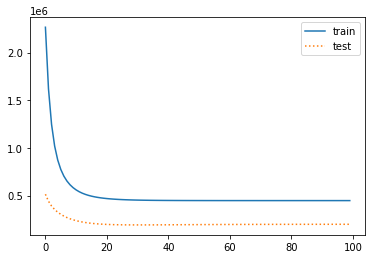

In [5]:
x_axis = list(range(model.num_epochs))
plt.plot(x_axis, model.train_loss, label = "train")
plt.plot(x_axis, model.test_loss, ':', label = "test")
plt.legend()
plt.show()

### With ridge penalty

In [6]:
model_ridge = GD_regression(num_epochs=100, l2_penalty=10)
model_ridge.fit(X_train, y_train, X_test, y_test)

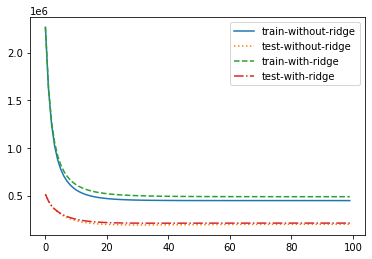

In [7]:
x_axis = list(range(model.num_epochs))
plt.plot(x_axis, model.train_loss, label = "train-without-ridge")
plt.plot(x_axis, model.test_loss, ':', label = "test-without-ridge")
plt.plot(x_axis, model_ridge.train_loss, '--', label = "train-with-ridge")
plt.plot(x_axis, model_ridge.test_loss, '-.', label = "test-with-ridge")
plt.legend()
plt.show()

In [8]:
from numpy import linalg as LA
print(LA.norm(model.weights, 2))
print(LA.norm(model_ridge.weights, 2))

187.17545901615978
161.7645420688599


## Liear regression using one layer FCN

### Without ridge penalty

In [9]:
class FCN_regression:
    def __init__(self, input_size, lr=1e-3, num_epochs=1000, l2_penalty=0):
        self.lr = lr
        self.num_epochs = num_epochs
        self.l2_penalty = l2_penalty
        self.train_loss = []
        self.test_loss = []
        self.model = nn.Linear(input_size, 1)
        self.criterion = nn.MSELoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr)  

    def fit(self, X_train, y_train, X_test, y_test):
        # initialize weights to be an array of zeros
        weights = np.zeros(X_train.shape[1])
        # iteration counter
        epoch = 0 
        # convert to tensor
        X_train = torch.from_numpy(X_train).float()
        X_test = torch.from_numpy(X_test).float()
        y_train = torch.from_numpy(y_train).float()
        y_test = torch.from_numpy(y_test).float()
        
        for epoch in range(self.num_epochs):
            # forward pass to calculate prediction
            y_predicted = self.model(X_train)
            # get current MSE loss
            loss_train = self.criterion(y_predicted, y_train)
            self.train_loss.append(loss_train.item())
            # add L2 penalty
            l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
            loss_train = loss_train + self.l2_penalty * l2_norm
            # backward pass to perform SGD
            self.optimizer.zero_grad()
            loss_train.backward()
            self.optimizer.step()
            # calculate and store test loss without gradient
            with torch.no_grad():
                y_test_pred = self.predict(X_test)
                loss_test = self.criterion(y_test_pred, y_test)
                self.test_loss.append(loss_test.item())

        return self

    # make class predictions for test set
    def predict(self, x):
        model = self.model.eval()
        outputs = model(x)
        model = self.model.train()
        return outputs

In [10]:
model = FCN_regression(input_size=X_train.shape[1], lr=1e-3, num_epochs=10000)
model.fit(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([80])) that is different to the input size (torch.Size([80, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


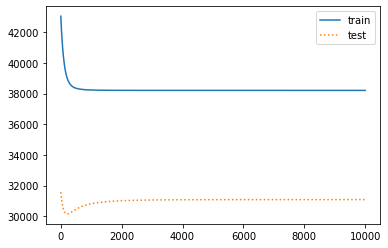

In [11]:
x_axis = list(range(model.num_epochs))
plt.plot(x_axis, model.train_loss, label = "train")
plt.plot(x_axis, model.test_loss, ':', label = "test")
plt.legend()
plt.show()

### With ridge penalty

In [12]:
model_ridge = FCN_regression(input_size=X_train.shape[1], lr=1e-3, num_epochs=10000, l2_penalty=0.1)
model_ridge.fit(X_train, y_train, X_test, y_test)

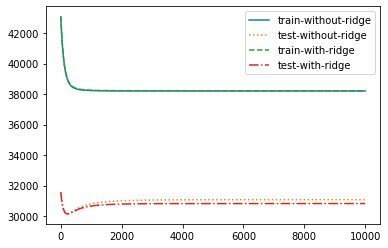

In [13]:
x_axis = list(range(model.num_epochs))
plt.plot(x_axis, model.train_loss, label = "train-without-ridge")
plt.plot(x_axis, model.test_loss, ':', label = "test-without-ridge")
plt.plot(x_axis, model_ridge.train_loss, '--', label = "train-with-ridge")
plt.plot(x_axis, model_ridge.test_loss, '-.', label = "test-with-ridge")
plt.legend()
plt.show()